# Introductory Notes

* Much of the content presented here was adapted from `fast.ai` if you have questions or would like more details I would recommend viewing their website
* `fast.ai` has built a package that serves as a wrapper for `pytorch` with a lot of utility functions.
    * This is a good starting place but as you progress you will likely want to shift to more flexible packages for deep learning

# Deep learning packages

1. TensorFlow - This is based out of google
    * Flexible architecture
    * Written in Python

2. Torch is a scientific computing framework that offers wide support for machine learning algorithms. 
    * It is a Lua-based deep learning framework and is used widely amongst industry giants such as Facebook, Twitter, and Google. 
    * Very flexible for complex DNNs
    * Displacing use of Tensorflow

3. Keras - a lightweight and simple implementation of Tensorflow
    * A simple version of TensorFlow which is easier to use. 
    * It has a nice simple interface
    * Keras was purchased by Google and is now part of the core API for TensorFlow

3. Caffe - Deep learning framework that is supported with interfaces like C, C++, Python, and MATLAB as well as the command line interface
    * Good because it can be used in a lot of languages
    * Very fast
    * limited implementation of complex neural networks

4. DeepLearning4J - A Java based deep learning platform
    * Can use Hadoop and spark. Can run servers on web interfaces

# What people say about deep learning which are either pointless or untrue
![](./images/1_5.png)

# Rather than just talking about theory for awhile lets do something!

# What's your pet

* we will build our first image classifier from scratch, and see if we can achieve world-class results. 

This is some useful code. It makes sure that that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [4]:
!pip install fastai --user

  Using cached https://files.pythonhosted.org/packages/83/db/794db47024a26c75635c35f0ee5431aa8b528e895ad1ed958041290f83f7/fastprogress-0.1.21-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/74/ee/d872c12ea508f9cca4cf0d7b91fc5a5e476cec77628a66795ec5a585a67f/torchvision-0.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b9/01/fcb8ae3e836fea5c11fdb4c074d27b52bdf74b47bd9bb28a811b7ab37d49/spacy-2.2.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6c/5b/ae4da6230eb48df353b199f53532c8407d0e9eb6ed678d3d36fa75ac391c/preshed-3.0.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/86/85/40b8f66c2dd8f4fd9f09d59b22720cffecf1331e788b8a0cab5bafb353d1/plac-1.1.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/73/fc/10eeacb926ec1e88cd62f79d9ac106b0a3e3fe5ff1690422d88c29bd0909/murmurhash-1.0.2-cp37-cp37m-manylinux1_x86_64.whl
  Usin

In [5]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [7]:
bs = 64 # sets the batch size
#bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. 
* According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. 
* Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [8]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [10]:
path = untar_data(URLs.PETS); path

PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet')

In [11]:
path.ls()

[PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/annotations')]

In [12]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. 
* We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. 
* Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. 
* We will need to extract them to be able to classify the images into the correct categories. 
* Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [13]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/chihuahua_126.jpg'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/german_shorthaired_97.jpg'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/Bombay_157.jpg'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/Bengal_12.jpg')]

In [14]:
#np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [15]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

With this factory method, we can basically say:

- path_img: a path containing images
- fnames: a list of file names
- pat: a regular expression (i.e. pattern) to be used to extract the label from the file name
- ds_tfm: we'll talk about transforms later
- size: what size images do you want to work with.

This might seem weird because images have size. This is a shortcoming of current deep learning technology which is that a GPU has to apply the exact same instruction to a whole bunch of things at the same time in order to be fast. If the images are different shapes and sizes, you can't do that.

In fastai, everything you model with is going to be a DataBunch object. 
DataBunch object contains 2 or 3 datasets:
* Training data, 
* Validation data 
* Test data. 

For each of those, it contains your images and your labels, your texts and your labels, or your tabular data and your labels, or so forth. And that all sits there in this one place(i.e. `data`). 


Something we will learn more about in a little bit is normalization. But generally in nearly all machine learning tasks, you have to make all of your data about the same "size" - they are specifically about the same mean and standard deviation.  So there is a normalize function that we can use to normalize our data bunch in that way.

It means that the pixel values start out from 0 to 255. 
* some channels might tend to be really bright, some might tend to be really not bright at all, some might vary a lot, and some might not very much at all. 
**It really helps train a deep learning model if each one of those red green and blue channels has a mean of zero and a standard deviation of one.** 

If your data is not normalized, it can be quite difficult for your model to train well. So if you have trouble training a model, one thing to check is that you've normalized it.

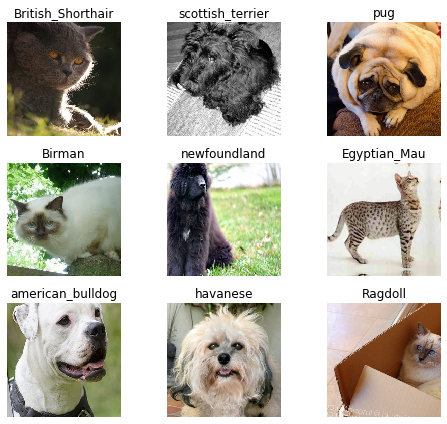

In [16]:
data.show_batch(rows=3, figsize=(7,6))

In [17]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

It is important to know that `data.c` is a really important piece of information that is something like, or at least for classification problems it is, the number of classes. 

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. 

We will train for 4 epochs (4 cycles through all our data).

 - **DataBunch**: A general fastai concept for your data, and from there, there are subclasses for particular applications like ImageDataBunch
 - **Learner**: A general concept for things that can learn to fit a model. From that, there are various subclasses to make things easier in particular, there is a convnet learner  (something that will create a convolutional neural network for you).

In [18]:
# downloads and instanciates the model
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jca318/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 107MB/s] 


* `data`: What's your data. Not surprisingly, it takes a data bunch.
* `arch`: What's your architecture. There are lots of different ways of constructing a convolutional neural network.

In [19]:
# This shows the model
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

So now we have a ConvLearner, we can fit it. You can just use a method called `fit` but in practice, you should nearly always use a method called `fit_one_cycle`. 

In short, one cycle learning is [a paper](https://arxiv.org/pdf/1803.09820.pdf) that was released in April and turned out to be dramatically better both more accurate and faster than any previous approach. Again, I don't want to teach you how to do 2017 deep learning. In 2018/19, the best way to fit models is to use something called one cycle. 

In [20]:
# Trains the model for 4 epochs
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.382692,0.348784,0.110284,00:28
1,0.603002,0.320281,0.100812,00:25
2,0.392610,0.246856,0.079161,00:24
3,0.279884,0.235521,0.073072,00:24


We just trained a model. We don't know exactly what that involved or how it happened but we do know that with 3 or 4 lines of code, we've built something which smashed the accuracy of the state-of-the-art of 2012. 6% error certainly sounds like pretty impressive for something that can recognize different dog breeds and cat breeds, but we don't really know why it work, but we will. That's okay.

In [21]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. 
* We will try to see if what the model predicted was reasonable or not. 
    * In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Plot the confusion matrix, we can see that the distribution is heavily skewed: 
* the model makes the same mistakes over and over again but it rarely confuses other categories. 
* This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

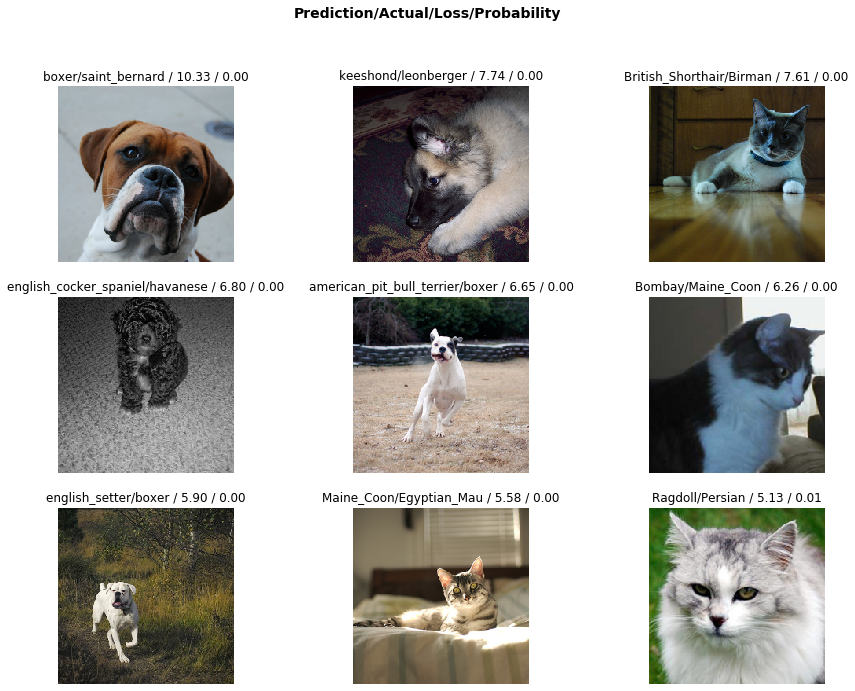

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

In [24]:
doc(interp.plot_top_losses)

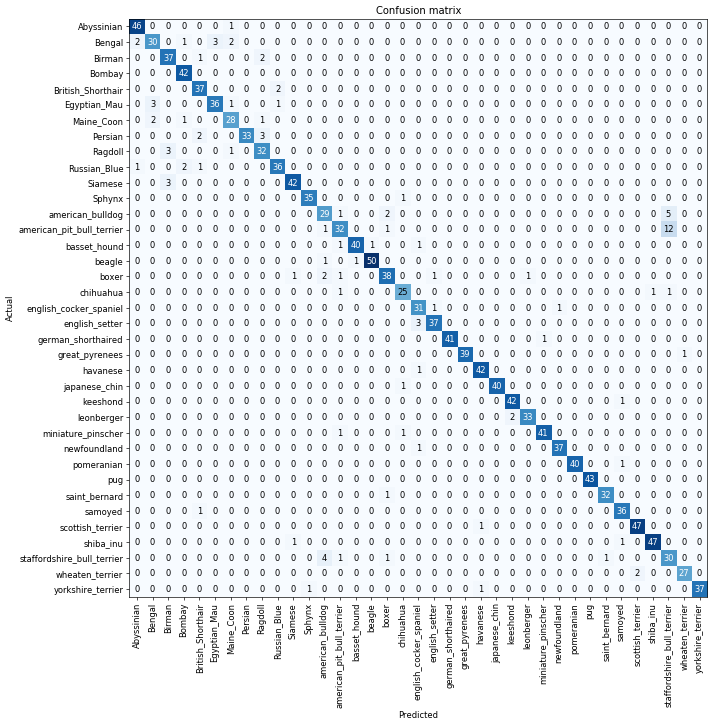

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 12),
 ('american_bulldog', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Persian', 'Ragdoll', 3),
 ('Ragdoll', 'Birman', 3),
 ('Siamese', 'Birman', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Persian', 'British_Shorthair', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_bulldog', 'boxer', 2),
 ('boxer', 'american_bulldog', 2),
 ('leonberger', 'keeshond', 2),
 ('wheaten_terrier', 'scottish_terrier', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

What we really want to do is to go back and train the whole model. This is why we pretty much always use this two stage process. 
* By default, when we call `fit` or `fit_one_cycle` on a ConvLearner, it'll just fine-tune these few extra layers added to the end and it will run very fast. 
* It will basically never overfit but to really get it good, you have to call `unfreeze`. `unfreeze` is the thing that says please train the whole model. Then I can call fit_one_cycle again.

In [27]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.756396,0.400229,0.121110,00:25


## This got much worse, why? 

* We tried to update the whole model with the same big learning rate. 

There is a [a fantastic paper](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) by Matt Zeiler. 
* They wrote a paper showing how you can visualize the layers of a convolutional neural network. A convolutional neural network, which we will learn mathematically about what the layers 
* ResNet34 has 34 layers, and ResNet50 has 50 layers, but let's look at layer one. There's this very simple computation which is a convolution if you know what they are. 
* What comes out of this first layer? Well, we can actually visualize these specific coefficients, the specific parameters by drawing them as a picture. 

In [29]:
learn.load('stage-1');

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


This will plot the result of our LR finder and what this basically shows you is this key parameter called a learning rate. 
* The learning rate basically says how quickly am I updating the parameters in my model. 
* The x-axis one here shows me what happens as I increase the learning rate. The y axis show what the loss is. 

* So you can see, once the learning rate gets passed 10^-4, my loss gets worse. It actually so happens, in fact I can check this if I press <kbd>shift</kbd>+<kbd>tab</kbd> here, my learning defaults to 0.003.
* So you can see why our loss got worse. Because we are trying to fine-tune things now, we can't use such a high learning rate. 
* So based on the learning rate finder, I tried to pick something well before it started getting worse. So I decided to pick `1e-6`. 
    * But there's no point training all the layers at that rate, because we know that the later layers worked just fine before when we were training much more quickly. 
    * So what we can actually do is we can pass a range of learning rates to `learn.fit_one_cycle`. And we do it like this:

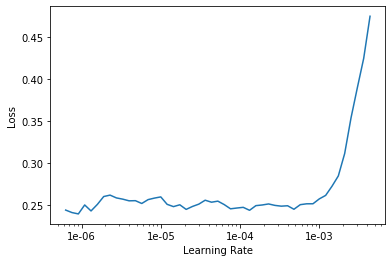

In [31]:
learn.recorder.plot()

You use this keyword in Python called `slice` and that can take a start value and a stop value and basically what this says is train the very first layers at a learning rate of 1e-6, and the very last layers at a rate of 1e-4, and distribute all the other layers across that (i.e. between those two values equally). 

A good rule of thumb is after you unfreeze (i.e. train the whole thing), pass a max learning rate parameter, pass it a slice, make the second part of that slice about 10 times smaller than your first stage. 
* Our first stage defaulted to about 1e-3 so it's about 1e-4. 
* The first part of the slice should be a value from your learning rate finder which is well before things started getting worse. So you can see things are starting to get worse

In [35]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.334555,0.286700,0.094046,00:25
1,0.316483,0.277420,0.084574,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.295997,0.262423,0.081867,00:24
1,0.263782,0.263191,0.079838,00:25


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. You can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [36]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [37]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jca318/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.4MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


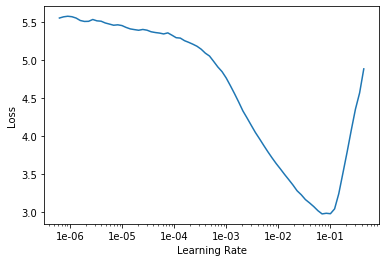

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.730968,0.308917,0.098106,00:39
1,0.517113,0.322453,0.095399,00:39
2,0.393311,0.296822,0.088633,00:38
3,0.329296,0.264250,0.071719,00:39
4,0.274339,0.237531,0.063599,00:38
5,0.185360,0.228464,0.062923,00:38
6,0.134867,0.207341,0.058863,00:39
7,0.105461,0.195153,0.058863,00:39


In [42]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [43]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.096533,0.192956,0.056834,00:51
1,0.093099,0.206806,0.058187,00:49
2,0.090523,0.201488,0.058187,00:50


If it doesn't, you can always go back to your previous model.

In [44]:
learn.load('stage-1-50');

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

In [46]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('Birman', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Persian', 'Ragdoll', 2),
 ('Ragdoll', 'Persian', 2),
 ('Ragdoll', 'Siamese', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Siamese', 'Birman', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'havanese', 2)]

## Other data formats

In [54]:
path = untar_data(URLs.MNIST_SAMPLE, force_download=True); path

PosixPath('/home/jca318/.fastai/data/mnist_sample')

# Scenario 1: Labels are folder names

In [55]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

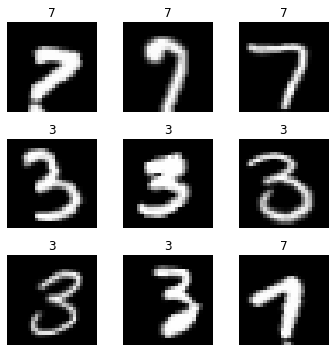

In [56]:
data.show_batch(rows=3, figsize=(5,5))

In [57]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.196345,0.104191,0.968597,00:08
1,0.126163,0.055650,0.980373,00:08


In [58]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


# Scenario 2: CSV file

In [59]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

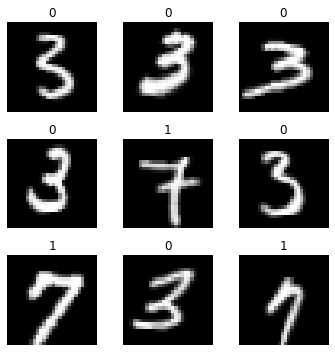

In [60]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [61]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

# Scenario 3: Using regular expression

In [62]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/jca318/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/jca318/.fastai/data/mnist_sample/train/3/21102.png')]

In [63]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

# Scenario 4: Something more complex

In [64]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

# Scenario 5: You need something even more flexible

In [65]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [66]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']